In [166]:
from aptamer_transformer.model import *
from aptamer_transformer.factories_model_loss import *
from aptamer_transformer.data_utils import *
from aptamer_transformer.dataset import *

import torch
import torch.nn.functional as F
import cupy as cp

from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import yaml
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.style.use(['science','nature', 'no-latex'])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

raw_data = read_data_files(cfg)

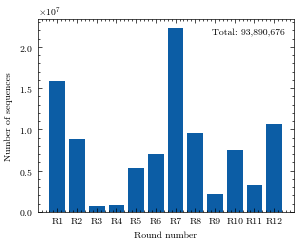

In [3]:
raw_data_values = list(raw_data.values())
len_of_raw_data = [len(raw_data_value) for raw_data_value in raw_data_values]
raw_data_keys = list(raw_data.keys())
round_numbers = [raw_data_key.split('_')[-1].split('.')[0] for raw_data_key in raw_data_keys]

plt.bar(round_numbers, len_of_raw_data)
plt.xlabel('Round number')
plt.ylabel('Number of sequences')
plt.legend([f'Total: {sum(len_of_raw_data):,}'], handlelength=0, handletextpad=0)


In [4]:
normalized_counters_data = normalized_counters(raw_data)

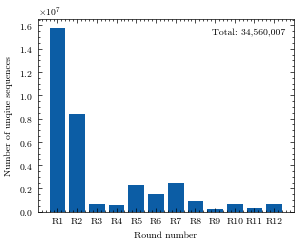

In [5]:
count_data_values = list(normalized_counters_data.values())
len_of_count_data = [len(raw_data_value) for raw_data_value in count_data_values]

plt.bar(round_numbers, len_of_count_data)
plt.xlabel('Round number')
plt.ylabel('Number of unqiue sequences')
plt.legend([f'Total: {sum(len_of_count_data):,}'], handlelength=0, handletextpad=0)


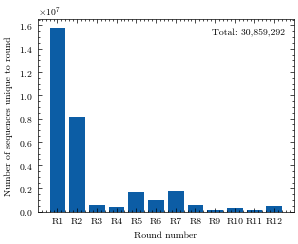

In [104]:
def unique_keys_in_subdicts(main_dict):
    # This will store the keys that are unique to each sub-dictionary
    unique_keys = {sub_dict: [] for sub_dict in main_dict}

    # Iterate over all sub-dictionaries
    for sub_dict, current_dict in main_dict.items():
        # Compare keys in the current sub-dictionary with keys in all other sub-dictionaries
        for key in current_dict:
            if all(key not in other_dict for other_sub_dict, other_dict in main_dict.items() if other_sub_dict != sub_dict):
                unique_keys[sub_dict].append(key)

    return unique_keys

unique_keys = unique_keys_in_subdicts(normalized_counters_data)
len_unique_keys = [len(keys) for keys in unique_keys.values()]

plt.bar(round_numbers, len_unique_keys)
plt.ylabel('Number of sequences unique to round')
plt.xlabel('Round number')
plt.legend([f'Total: {sum(len_unique_keys):,}'], handlelength=0, handletextpad=0)

Text(0, 0.5, 'Number of sequences')

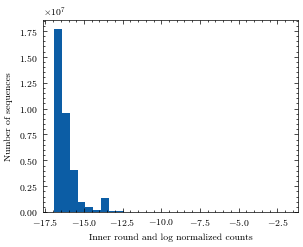

In [93]:
normalized_counts = np.concatenate(np.array([list(count.values()) for count in count_data_values], dtype='object'))
log_normalized_counts = np.log(normalized_counts)
plt.hist(log_normalized_counts, bins=30)
plt.xlabel('Inner round and log normalized counts')
plt.ylabel('Number of sequences')
# plt.ylim(0, 1_000_000)

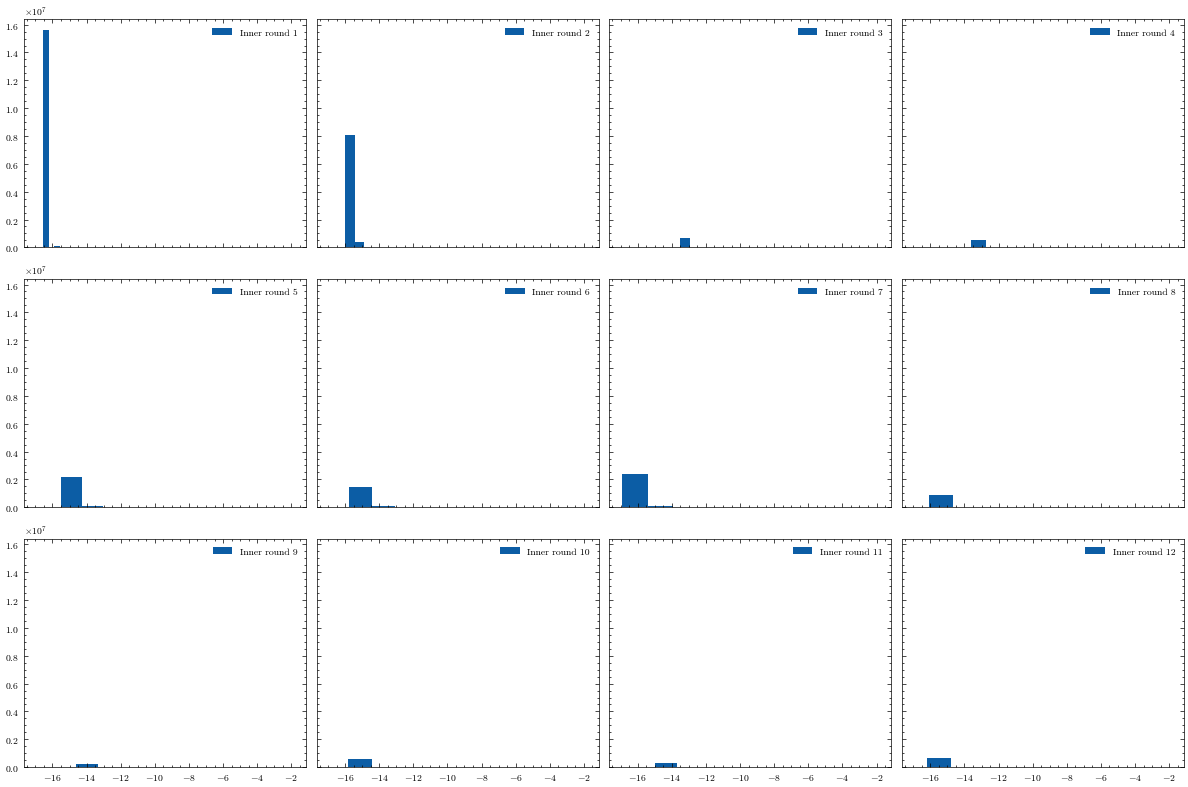

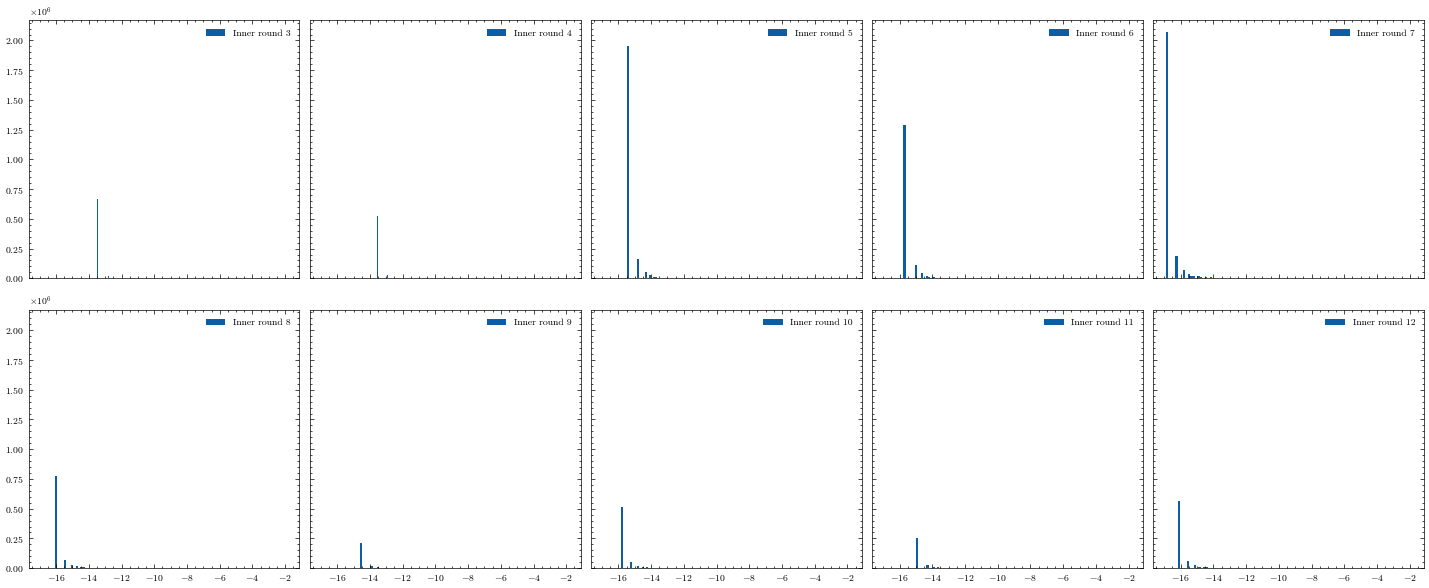

In [95]:
normalized_counts = np.array([list(count.values()) for count in count_data_values], dtype='object')

fig, ax = plt.subplots(3,4, figsize=(12,8), sharex=True, sharey=True)
for round, counts in enumerate(normalized_counts):
    row = round//4
    col = round%4
    ax[row, col].hist(np.log(counts), bins=10, label=f'Inner round {round +1}')
    ax[row,col].legend()
plt.tight_layout()

fig, ax = plt.subplots(2,5, figsize=(12*1.2,5*1.2), sharex=True, sharey=True)
for round, counts in enumerate(normalized_counts[2:]):
    row = round//5
    col = round%5
    ax[row, col].hist(np.log(counts), bins=100, label=f'Inner round {round +3}')
    ax[row,col].legend()
plt.tight_layout()


In [46]:
enrichment_scores = all_enrichments(normalized_counters_data)

<BarContainer object of 12 artists>

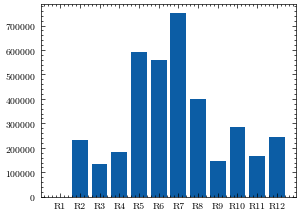

In [119]:
def extract_and_count_subkeys(enrichment_scores, key):
    unique_subkeys = set()  # Using a set to store unique keys
    for higher_order_key, sub_dict in enrichment_scores.items():
        if key in higher_order_key:
            unique_subkeys.update(sub_dict.keys())
    return len(unique_subkeys)

# Function to extract the round number from the file name
def extract_round_number(filename):
    # Split the filename on '_', take the second part, and then remove the '.txt' part
    # Finally, convert the number to an integer for proper sorting
    return int(filename.split('_R')[1].split('.txt')[0])



# Now we will count the unique sub-keys for each higher order key
unique_keys = set()
for keys in enrichment_scores.keys():
    unique_keys.update(keys)

# Initialize a dictionary to hold the counts for each higher order key
unique_subkeys_count = {}

# Count the number of unique sub-keys for each higher order key
for key in unique_keys:
    unique_subkeys_count[key] = extract_and_count_subkeys(enrichment_scores, key)


# Sorting the dictionary by the round number
sorted_data = dict(sorted(unique_subkeys_count.items(), key=lambda item: extract_round_number(item[0])))

plt.bar(round_numbers, list(sorted_data.values()))

In [ ]:
enrichment_scores()

In [143]:
log_normalize_enrichment = log_normalize_enrichment_scores(enrichment_scores)

In [144]:
log_normalize_enrichment

,Sequence,mean,sum,max,min,count
0,AAAAAAAAAAACGGGGGGGGGGGGTGGGGGGGGGGGTCCT,-0.339708,-0.339708,-0.339708,-0.339708,1
1,AAAAAAAAAAACGGGGGGGGGGGGTGGGGTGGGGGGTCCT,-1.176262,-1.176262,-1.176262,-1.176262,1
2,AAAAAAAATGGGGGGGGCGGGGGGGGGGGTCTGTTTATTT,-0.336079,-0.336079,-0.336079,-0.336079,1
3,AAAAAAAATGGGGGGGGGGGGGGGGGGGGTCTGTTTATTT,-2.214411,-6.643234,-1.193779,-3.321617,3
4,AAAAAAACGGCATCGCTAGGCATCAGGTCCCATCCGGTTA,0.152535,0.457605,2.486318,-2.257516,3
...,...,...,...,...,...,...
1287746,TTTTTTTTTTTTTTGGGGGGTTGGGGGGGGCGGGGGTCCC,0.844015,0.844015,0.844015,0.844015,1
1287747,TTTTTTTTTTTTTTTGGGGGGGGGCGGGGGGGGGGGTCCC,2.315378,2.315378,2.315378,2.315378,1
1287748,TTTTTTTTTTTTTTTGGGGGGGGGGGGGGGGGGGGGTCCC,-0.312687,-0.312687,-0.312687,-0.312687,1
1287749,TTTTTTTTTTTTTTTGGGGGGTGGGGGGGGGGGGGGTCCC,0.844015,0.844015,0.844015,0.844015,1


In [153]:
def tokenize_sequence(seq, max_length, padding_char='N'):
    seq += padding_char * (max_length - len(seq))  # Pad the sequence
    return list(seq)


max_seq_length = max(log_normalize_enrichment['Sequence'].apply(len))
sequence_tokenized = np.array([tokenize_sequence(seq, max_seq_length) for seq in log_normalize_enrichment['Sequence']])
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
sequence_encoded = onehot_encoder.fit_transform(sequence_tokenized)


In [155]:
sequence_flattened = sequence_encoded.reshape(log_normalize_enrichment.shape[0], -1)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(sequence_flattened, log_normalize_enrichment['mean'].values, test_size=0.2, random_state=42)
# X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(sequence_flattened, log_normalize_enrichment['Discretized_Frequency'].values, test_size=0.2, random_state=42)


In [163]:
X_train_regression_gpu = cp.array(X_train_regression)
y_train_regression_gpu = cp.array(y_train_regression)

AttributeError: module 'cupy' has no attribute 'array'

In [167]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',
    colsample_bytree=0.7,  # Updated
    learning_rate=0.1,     # Updated
    max_depth=10,          # Updated
    alpha=5,               # Updated
    n_estimators=100,      # Updated
    tree_method='hist',    # Assuming you're still using GPU acceleration
    device='gpu'           # Assuming you're still using GPU acceleration
)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=0.7,  # Updated
    learning_rate=0.1,     # Updated
    max_depth=10,          # Updated
    alpha=5,               # Updated
    n_estimators=100,      # Updated
    tree_method='hist',    # Assuming you're still using GPU acceleration
    device='gpu'
)

model.fit(X_train_regression, y_train_regression)

y_pred = model.predict(X_test_regression)

# R-squared
r2 = r2_score(y_test_regression, y_pred)
print("R-squared: %f" % r2)

XGBoostError: [16:52:14] /workspace/src/objective/regression_obj.cu:635: TweedieRegression: label must be nonnegative
Stack trace:
  [bt] (0) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xa8dc0a) [0x14e65fcb3c0a]
  [bt] (1) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xaa2e17) [0x14e65fcc8e17]
  [bt] (2) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x55f9ed) [0x14e65f7859ed]
  [bt] (3) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4900d1) [0x14e65f6b60d1]
  [bt] (4) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c0716) [0x14e65f6e6716]
  [bt] (5) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c5274) [0x14e65f6eb274]
  [bt] (6) /glade/work/mlsample/conda-envs/guess/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x14e65f387ef0]
  [bt] (7) /glade/work/mlsample/conda-envs/guess/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x14e7aa6d5a4a]
  [bt] (8) /glade/work/mlsample/conda-envs/guess/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x14e7aa6d4fea]

